In [73]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import gc

gc.collect()
torch.cuda.empty_cache()

#from torch.utils.tensorboard import SummaryWriter
#%reload_ext tensorboard
#log_folder = './logs9'
#writer = SummaryWriter()

In [74]:
def get_data():
    data_dir = './Data'
    
    transform = transforms.Compose(
    [transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])])

    trainSet = datasets.ImageFolder(data_dir + '/TrainSet', transform=transform)
    print(len(trainSet))
    validSet = datasets.ImageFolder(data_dir + '/ValidSet', transform=transform)
    testSet = datasets.ImageFolder(data_dir + '/TestSet', transform=transform)

    train = DataLoader(trainSet, batch_size=32, shuffle=True)
    valid = DataLoader(validSet, batch_size=32, shuffle=False)
    test = DataLoader(testSet, batch_size=32, shuffle=False)

    return train, valid,test

247


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


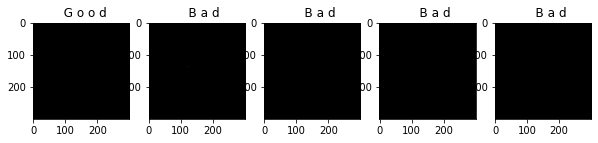

8


In [75]:
def train_imshow():
    classes = ('Bad', 'Good')
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()

train_loader, val_loader,test_loader = get_data()
train_imshow()
print(len(train_loader))

In [77]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 64, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 8192, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 1024)
        self.fc3 = nn.Linear(in_features=1024 , out_features=1)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        #print("bf flattening: ",x.shape)
        x = x.reshape(x.shape[0], -1)
        #print("after flattening: ",x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x

In [79]:
device="cpu"
model = Net().to(device)
model.train()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [82]:
epochs = 15

for epoch in range(epochs):
    epoch_loss =0
    epoch_accuracy = 0
    
    for data,label in train_loader:
        data= data.to(device)
        label = label.to(device)
        
        output = model(data)
        label = label.unsqueeze(-1)
        label = label.to(torch.float32)
        loss = criterion(output,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1)==label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))

Epoch : 1, train accuracy : 0.5261548757553101, train loss : 0.6931143999099731
Epoch : 2, train accuracy : 0.527683436870575, train loss : 0.6930818557739258
Epoch : 3, train accuracy : 0.5261548757553101, train loss : 0.6929404735565186
Epoch : 4, train accuracy : 0.523097813129425, train loss : 0.6929419040679932
Epoch : 5, train accuracy : 0.5261548757553101, train loss : 0.692877471446991
Epoch : 6, train accuracy : 0.5261548757553101, train loss : 0.6927440762519836
Epoch : 7, train accuracy : 0.5215693116188049, train loss : 0.6928196549415588
Epoch : 8, train accuracy : 0.5261548757553101, train loss : 0.6926969885826111
Epoch : 9, train accuracy : 0.5292119383811951, train loss : 0.6925444602966309
Epoch : 10, train accuracy : 0.53074049949646, train loss : 0.69244384765625
Epoch : 11, train accuracy : 0.52004075050354, train loss : 0.6927509903907776
Epoch : 12, train accuracy : 0.527683436870575, train loss : 0.6924931406974792
Epoch : 13, train accuracy : 0.5322690010070801

In [85]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        print(outputs)
        predicted_targets = outputs.argmax(dim=1)
        print(predicted_targets)
        total += labels.size(0)
        correct += (predicted_targets == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct // total} %')

tensor([[0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4899],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([[0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4899],
        [0.4900],
        [0.4899],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
        [0.4900],
    